# **Cardiac Arrhythmia Classification using Raw PPG**


---

By- Nakul C



## **a. Summary, At a Glance**

Cardiovascular diseases (CVDs)
stand as the leading global cause of death,
prompting the need for continuous monitor-
ing to detect them early in at-risk individu-
als. Traditional methods like electrocardiograms
(ECGs) have drawbacks such as false alarms
and discomfort from electrodes, prompting a
recent shift towards the use of photoplethys-
mogram (PPG) signals. PPG provides a non-
invasive, cost-effective way to assess cardiac ac-
tivity. This project utilizes PPG signals from a
reputable database to classify different cardiac
arrhythmias. Signal pre-processing techniques
are applied to remove noise and artifacts be-
fore feature extraction. A comprehensive set of
features is used, and classification is performed
using two machine learning Recurrent Neural
Network (RNN) algorithms: Long Short-Term
Memory (LSTM) and Bidirectional Long Short-
Term Memory (BLSTM)

## **b. Information about Dataset:**

The PPG (PhotoPlethysmoGraphy ) waveforms obtained from publicly accessible databases (specifically PhysioNet/Computing in Cardiology Chal-
lenge 2015) were utilized to train, validate, and
test classification models. These databases contain
over 750 raw waveforms from bedside monitors
in intensive care units (ICUs), each consisting of
two ECG leads and at least one pulsatile waveform
of either PPG or arterial blood pressure (ABP)
waveform for a duration of 5 min. Each waveform
is associated with an alarm that indicates either a
true or false arrhythmia event

---

# **Part A: Installing Packages and Basic Visualization of PPG**

## **A1: Installing Packages**

In [48]:
# Importing packages
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense
import os
import scipy.io
from scipy.signal import butter, filtfilt, find_peaks
#from google.colab import drive
import datetime
import wfdb
import requests
import pywt
import seaborn
import keras
import random
import numpy as np
import csv
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from os.path import join as osj
import pandas as pd

### **a. Getting Recordings' IDs**
The PPG recordings are named after Patients' IDs , We'll get the Id from the physionet website records section and store it in a csv file

In [49]:

url = 'https://archive.physionet.org/physiobank/database/challenge/2015/training/RECORDS'

response = requests.get(url)

# Check if the request was successful (status code 200)
if response.status_code == 200:

    text = response.text
    print("Successfully retrieve the patient Id's Status code:", response.status_code)
else:
    print("Failed to retrieve the text content. Status code:", response.status_code)

lines = text.strip().split('\n')

csv_file = 'record_names.csv'

with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows([[line] for line in lines])

print(f'CSV file "{csv_file}" has been created.')


Successfully retrieve the patient Id's Status code: 200
CSV file "record_names.csv" has been created.


We'll read the csv file and then store the records Id in the array for easy access

In [198]:

csv_file = 'record_names.csv'

patient_ids_df = pd.read_csv(csv_file, header=None)

patient_ids = patient_ids_df.to_numpy().reshape(-1)

print(patient_ids)

['v100s' 'v101l' 'v102s' 'a103l' 'a104s' 'a105l' 't106s' 't107l' 't108s'
 'a109l' 't110s' 'v111l' 't112s' 'v113l' 't114s' 'v115l' 't116s' 't117l'
 't118s' 'v119l' 'f120s' 'f121l' 'v122s' 'a123l' 'b124s' 'b125l' 'b126s'
 'v127l' 'v128s' 'f129l' 'f130s' 'v131l' 'v132s' 'v133l' 'a134s' 'v135l'
 'v136s' 'f137l' 'f138s' 'v139l' 'v140s' 'v141l' 'a142s' 'v143l' 'f144s'
 'a145l' 'v146s' 'v147l' 'v148s' 't149l' 't150s' 't151l' 'a152s' 'v153l'
 'v154s' 'v155l' 't156s' 't157l' 'v158s' 'v159l' 'v160s' 'a161l' 'v162s'
 'a163l' 'v164s' 'a165l' 'v166s' 'a167l' 'v168s' 'v169l' 'a170s' 'a171l'
 'a172s' 't173l' 't174s' 't175l' 'v176s' 'v177l' 'a178s' 'v179l' 'v180s'
 'v181l' 'v182s' 'b183l' 'b184s' 'a185l' 'a186s' 'b187l' 'v188s' 'f189l'
 'f190s' 't191l' 't192s' 't193l' 'v194s' 't195l' 'f196s' 'v197l' 'v198s'
 'v199l' 'v200s' 'v201l' 'v202s' 'a203l' 'v204s' 'v205l' 'v206s' 'v207l'
 't208s' 't209l' 'v210s' 'v211l' 'v212s' 't213l' 't214s' 'b215l' 'b216s'
 'v217l' 'v218s' 'a219l' 'b220s' 'v221l' 'v222s' 'a

### **b. Patient PPG signal and info extracting**
Downloading the content fromt he pysionet website

In [51]:


def extracting_database(record_name, data_dir='/home/nakul/Documents/Python/Arrhythmia_Classification_PPG/training'):

    os.makedirs(data_dir, exist_ok=True)

    base_url = 'https://archive.physionet.org/physiobank/database/challenge/2015/training/'

    #!wget -N {base_url + record_name + '.mat'} -P $data_dir
    #!wget -N {base_url + record_name + '.hea'} -P $data_dir # Uncomment these if you dont have the dataset in your drive

    record_path = os.path.join(data_dir, record_name + '.mat')
    hea_file_path = os.path.join(data_dir, record_name + '.hea')

    return record_path, hea_file_path

def extract_pleth_signal(record_path):

    mat_data = scipy.io.loadmat(record_path)

    signals = mat_data['val']

    pleth_signal = signals[2]  # PLETH is the third signal

    return pleth_signal

record_name = 'a103l'
record_path, hea_file_path = extracting_database(record_name)
pleth_signal = extract_pleth_signal(record_path)
print("PLETH Signal Values:")
pleth_signal


PLETH Signal Values:


array([6042, 6821, 5992, ..., 6454, 6385, 6301], dtype=int16)

In [52]:
def extract_pleth_info(file_path):

    pleth_info = {}

    with open(file_path, 'r') as file:
        lines = file.readlines()

        first_line_info = lines[0].split()
        pleth_info['file_name'] = first_line_info[0]
        pleth_info['num_signals'] = int(first_line_info[1])
        pleth_info['frequency'] = int(first_line_info[2])
        pleth_info['num_samples'] = int(first_line_info[3])

        last_three_lines = lines[-3:]
        pleth_info['ADC_resolution'] = last_three_lines[0].split()[1]
        pleth_info['ADC_gain'] = last_three_lines[0].split()[2]
        pleth_info['ADC_bits'] = int(last_three_lines[0].split()[3])
        pleth_info['ADC_zero'] = int(last_three_lines[0].split()[4])
        pleth_info['initial_value'] = int(last_three_lines[0].split()[5])
        pleth_info['check_sum'] = int(last_three_lines[0].split()[6])
        pleth_info['block_size'] = int(last_three_lines[0].split()[7])
        pleth_info['description'] = last_three_lines[0].split()[8]
        pleth_info['electrical_activity'] = last_three_lines[1].replace("#", "").replace("\n", "")
        pleth_info['validity'] = last_three_lines[2].replace("#", "").replace("\n", "")
        return pleth_info

file_path = hea_file_path
pleth_info = extract_pleth_info(file_path)
pleth_info


{'file_name': 'a103l',
 'num_signals': 3,
 'frequency': 250,
 'num_samples': 82500,
 'ADC_resolution': '16+24',
 'ADC_gain': '1.253e+04/NU',
 'ADC_bits': 16,
 'ADC_zero': 0,
 'initial_value': 6042,
 'check_sum': -17391,
 'block_size': 0,
 'description': 'PLETH',
 'electrical_activity': 'Asystole',
 'validity': 'False alarm'}

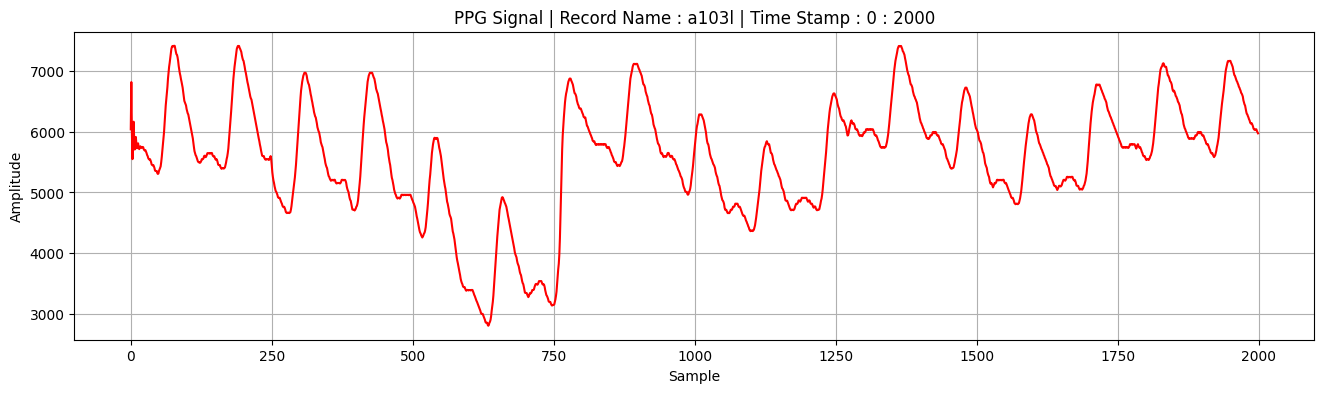

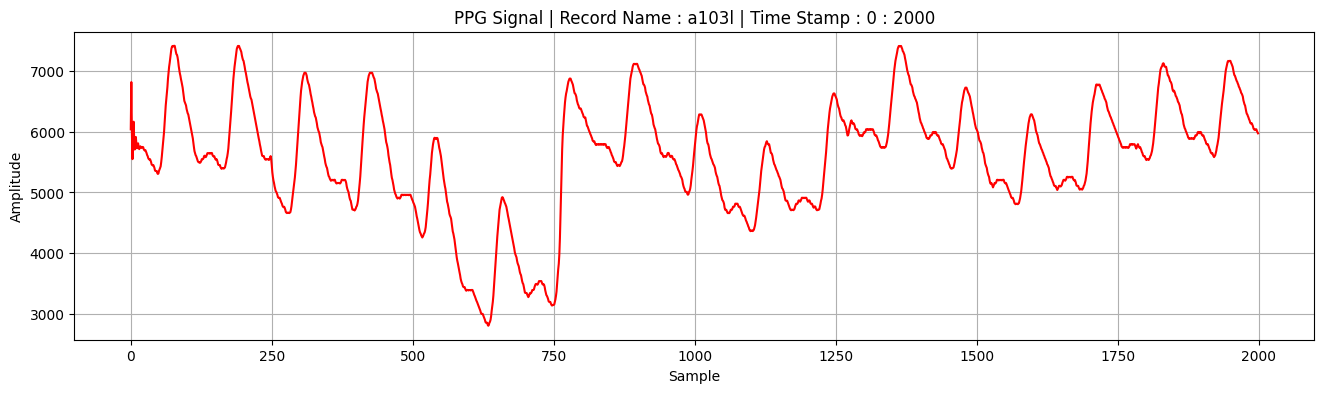

In [53]:

InitialTime = 0
FinalTime = 2000

plt.figure(figsize=(16, 4))
plt.plot(pleth_signal[InitialTime : FinalTime], color='red')
plt.title('PPG Signal | Record Name : ' + str(record_name) +" | Time Stamp : "+ str(InitialTime) + " : " + str(FinalTime))
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()



plt.figure(figsize=(16, 4))
plt.plot(pleth_signal[InitialTime : FinalTime], color='red')
plt.title('PPG Signal | Record Name : ' + str(record_name) +" | Time Stamp : "+ str(InitialTime) + " : " + str(FinalTime))
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()


### **c. All patients' PPG loading**

In [54]:
pleth_infos = {}
pleth_signals = {}

count = len(patient_ids)
i = 0
for patient_id in patient_ids:

    # Download the files and get their paths
    record_path, hea_file_path = extracting_database(patient_id)

    print("Signal of patient " + str(patient_id) + " extracted")

    # Extract PLETH signal
    pleth_signal = extract_pleth_signal(record_path)
    pleth_signals[patient_id] = pleth_signal

    print("PPG of patient " + str(patient_id) + " loaded")

    # Extract PLETH information
    pleth_info = extract_pleth_info(hea_file_path)
    pleth_infos[patient_id] = pleth_info

    print("Info of patient " + str(patient_id) + " loaded")

    print("PPG and info extracted for " + str(i+1) + " and " + str(count - i - 1) + " left.")

    i += 1


Signal of patient v100s extracted
PPG of patient v100s loaded
Info of patient v100s loaded
PPG and info extracted for 1 and 749 left.
Signal of patient v101l extracted
PPG of patient v101l loaded
Info of patient v101l loaded
PPG and info extracted for 2 and 748 left.
Signal of patient v102s extracted
PPG of patient v102s loaded
Info of patient v102s loaded
PPG and info extracted for 3 and 747 left.
Signal of patient a103l extracted
PPG of patient a103l loaded
Info of patient a103l loaded
PPG and info extracted for 4 and 746 left.
Signal of patient a104s extracted
PPG of patient a104s loaded
Info of patient a104s loaded
PPG and info extracted for 5 and 745 left.
Signal of patient a105l extracted
PPG of patient a105l loaded
Info of patient a105l loaded
PPG and info extracted for 6 and 744 left.
Signal of patient t106s extracted
PPG of patient t106s loaded
Info of patient t106s loaded
PPG and info extracted for 7 and 743 left.
Signal of patient t107l extracted
PPG of patient t107l loaded


In [55]:
pleth_infos[str(patient_ids[400])]

{'file_name': 'f500s',
 'num_signals': 4,
 'frequency': 250,
 'num_samples': 75000,
 'ADC_resolution': '16+24',
 'ADC_gain': '47.8/mmHg',
 'ADC_bits': 16,
 'ADC_zero': 0,
 'initial_value': 4912,
 'check_sum': 23760,
 'block_size': 0,
 'description': 'ABP',
 'electrical_activity': 'Ventricular_Flutter_Fib',
 'validity': 'False alarm'}

In [56]:
unique_frequencies = set()

for signal_data in pleth_infos.values():
    unique_frequencies.add(signal_data['frequency'])

print("Unique sample frequencies:", unique_frequencies)

Unique sample frequencies: {250}


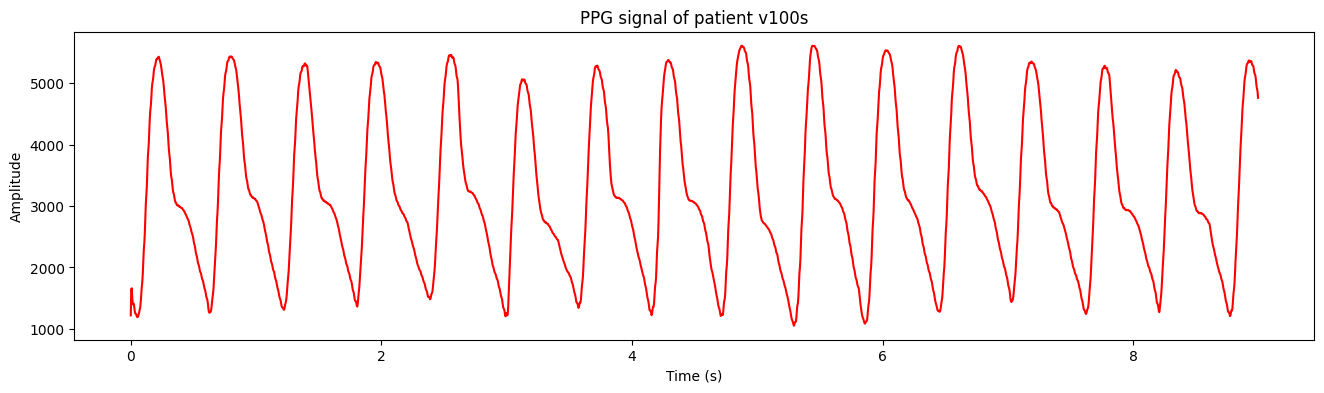

In [57]:
def plot_ppg_signal(patient_id, starting_time, ending_time):
    pleth_info = pleth_infos[str(patient_id)]
    sampling_frequency = pleth_info['frequency']

    starting_signal_point = int(starting_time * sampling_frequency)
    ending_signal_point = int(ending_time * sampling_frequency)

    x = np.arange(starting_time, ending_time, 1 / sampling_frequency)

    signal = pleth_signals[str(patient_id)][starting_signal_point:ending_signal_point]

    plt.figure(figsize=(16, 4))
    plt.plot(x, signal, color='red')
    plt.title(f'PPG signal of patient {patient_id}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()

plot_ppg_signal(patient_ids[0], 0, 9)


---

# **Part B: Pre-Processing the Signal**




### **B1: Bandpass Filter**
Filtration of the signal utilizing a bandpass filter between (0.05 Hz to 30 Hz).

Args:
- signal: The input signal.
- lowcut: The low cutoff frequency of the bandpass filter.
- highcut: The high cutoff frequency of the bandpass filter.
- fs: The sampling frequency of the signal.

Returns:
- filtered_signal: The filtered signal.

In [58]:
def bandpass_filter(signal, lowcut, highcut, fs):

    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    order = 3  # Filter order
    b, a = butter(order, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

### **B2: Moving Average Filter**
 It works by averaging a window of adjacent samples in the signal, shifting the window along the signal, and replacing each sample with the average value of the samples within the window

Args:
- signal: The input signal.
- window_size: The size of the moving average window.

Returns:
- smoothed_signal: The smoothed signal.

In [59]:
def moving_average(signal, window_size):

    smoothed_signal = np.convolve(signal, np.ones(window_size) / window_size, mode='same')
    return smoothed_signal


### **B3: Baseline Wandering Removal**
Baseline wandering refers to the low-frequency fluctuation or drift observed in physiological signals, such as electrocardiogram (ECG) or photoplethysmogram (PPG), caused by various factors including respiration, body movement, electrode or sensor contact issues, and muscle activity. It appears as a slow, periodic variation superimposed on the actual signal of interest.

Baseline wandering removal is the process of eliminating or reducing this low-frequency fluctuation from the signal while preserving the underlying information.

Args:
- signal: The input signal.

Returns:
- denoised_signal: The denoised signal.

In [60]:
def remove_baseline_wandering(signal):

    wavelet = 'sym8'  # Wavelet type
    level = 4  # Decomposition level
    coeffs = pywt.wavedec(signal, wavelet, level=level)

    # Zero out the detail coefficients
    coeffs = [coeffs[0]] + [np.zeros_like(coeff) for coeff in coeffs[1:]]

    denoised_signal = pywt.waverec(coeffs, wavelet)
    return denoised_signal

### **B4: Normalisation**
The goal of normalization is to bring the data within a similar scale, typically between 0 and 1 or -1 and 1, to ensure that all features contribute equally to the analysis and to prevent certain features from dominating others due to differences in their scales.

Args:
- signal: The input signal.

Returns:
- normalized_signal: The normalized signal.

In [61]:
def normalize_signal(signal):

    normalized_signal = (signal - np.min(signal)) / (np.max(signal) - np.min(signal))
    return normalized_signal


### **B5: Segmentation**
Each waveform was segmented into 10-s


Args:
- signal: The input signal.
- segment_length: The length of each segment in seconds.
- fs: The sampling frequency of the signal.

Returns:
- segmented_signal: A list of segmented signals.

In [62]:
def segment_signal(signal, segment_length, fs):

    num_samples_per_segment = int(segment_length * fs)
    num_segments = len(signal) // num_samples_per_segment
    segmented_signal = [signal[i * num_samples_per_segment: (i + 1) * num_samples_per_segment]
                        for i in range(num_segments)]
    return segmented_signal

* Firstly, Each waveform was segmented into 10-s
* The preprocessing includes filtration of the signal utilizing a bandpass filter between (0.05 Hz to 30 Hz).
* The signal smoothing using moving average filter
* Then, the baseline wandering was removed using wavelet transform
* Followed with signal normalization.


In [63]:
fs = pleth_info['frequency']

segmented_signal = segment_signal(pleth_signal, 10, fs)

processed_segments = []

for segment in segmented_signal:
    segment_processed = bandpass_filter(segment, lowcut=0.05, highcut=30, fs=fs)
    segment_processed = moving_average(segment_processed, window_size=int(0.02*fs))
    segment_processed = remove_baseline_wandering(segment_processed)
    segment_processed = normalize_signal(segment_processed)

    processed_segments.append(segment_processed)


## **Plotting the Signal Before and After processing**

In [64]:
def plot_ppg_signal_sampled(pleth_signal, fs, starting_time, ending_time):

    starting_signal_point = int(starting_time * fs)
    ending_signal_point = int(ending_time * fs)

    x = np.arange(starting_time, ending_time, 1 / fs)

    signal = pleth_signal[starting_signal_point:ending_signal_point]

    plt.figure(figsize=(16, 4))
    plt.plot(x, signal, color='red')
    plt.title(f'PPG signal of patient')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()

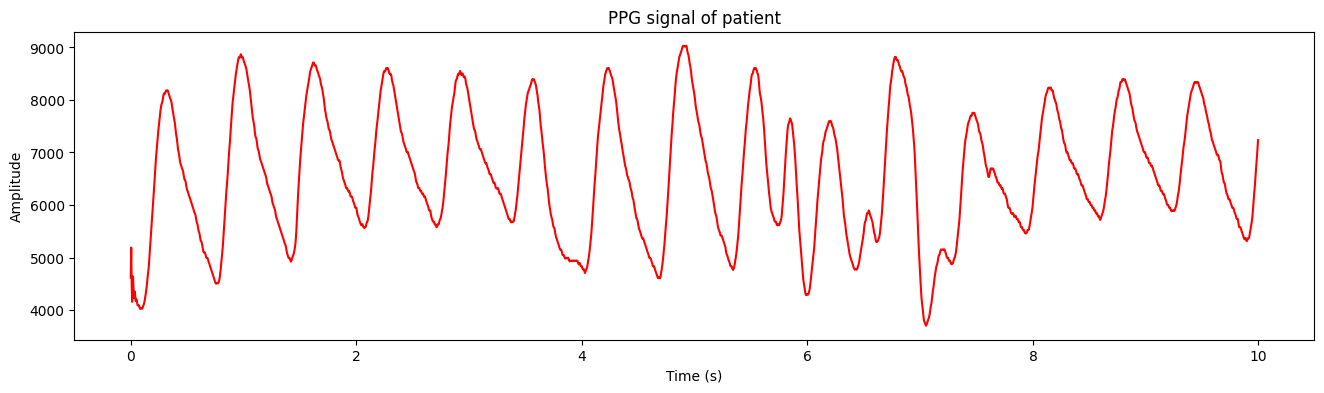

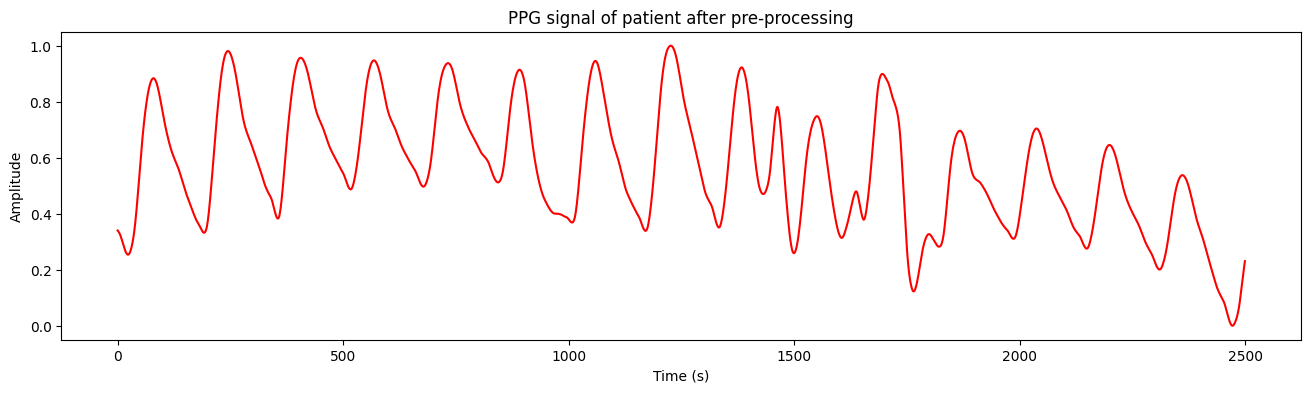

In [65]:
plot_ppg_signal_sampled(pleth_signal, fs, 0, 10)

plt.figure(figsize=(16, 4))
plt.plot(processed_segments[0], color='red')
plt.title(f'PPG signal of patient after pre-processing')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

#### **Pulse Width Extraction**

In [66]:

def calculate_pulse_width(peak_window, fs):
    pw = len(peak_window) / fs
    return pw

#### **Full width at half maximum Extraction**

In [67]:

def calculate_fwhm(peak_window, fs):
    max_index = np.argmax(peak_window)
    half_max = peak_window[max_index] / 2
    left_indices = np.where(peak_window[:max_index] <= half_max)[0]
    right_indices = np.where(peak_window[max_index:] <= half_max)[0] + max_index
    if len(left_indices) == 0 or len(right_indices) == 0:
        return 0

    left_index = left_indices[-1]
    right_index = right_indices[0]
    fwhm = (right_index - left_index) / fs

    return fwhm

---

## **Feature Extraction Extraction**


* **Signal Amplitude (sa)**: The maximum amplitude of the PPG waveform, representing the peak blood volume.
* **Dominant frequency amplitude (Da)**: The amplitude corresponding to the dominant frequency component in the PPG signal.
* **Spectral Amplitude (SA)**: The maximum amplitude in the frequency domain of the PPG signal.
* **Dominant frequency (DA)**: The frequency with the highest amplitude in the PPG signal, often corresponding to the heart rate.
* **Signal Duration (St)**: The duration of the PPG signal, indicating the time span over which measurements are taken.
* **Dominant frequency Duration (Dt)**: The duration of the dominant frequency component in the PPG signal.
* **Peak Index (PI)**: The index of the peak in the PPG signal, indicating the position of the peak in the time series.
* **Peak to Peak Index (PPI)**: The index of the peak-to-peak interval in the PPG signal.
* **Pulse Width (PW)**: The width of the pulse in the PPG signal, representing the duration of a heartbeat.
* **Full Width at Half Maximum (FWHM)**: The width of the peak at half of its maximum amplitude, often related to pulse duration or shape.
* **Spectral Entropy (Spectral\_entropy)**: Entropy of the PPG signal in the frequency domain, providing information about the signal's complexity.
* **Rise Time (Rise\_time)**: The time taken by the PPG signal to rise from a specified low level to a specified high level, indicating the rate of increase in blood volume.
* **Fall Time (Fall\_time)**: The time taken by the PPG signal to fall from a specified high level to a specified low level, indicating the rate of decrease in blood volume.
* **Amplitude Modulation Depth (Amplitude\_modulation\_depth)**: The depth of amplitude modulation in the PPG signal, representing variations in blood volume.
* **Energy (Energy)**: The energy of the PPG signal, providing overall information about signal strength.
* **Zero Crossing Rate (Zero\_crossing\_rate)**: The rate at which the PPG signal changes its sign, related to the frequency content and waveform shape.
* **Mean**: Represents the average value of the PPG signal, indicating its typical intensity.
* **Median**: The middle value of the PPG signal's distribution, providing insight into its central tendency.
* **Standard Deviation**: Measures the dispersion or spread of the PPG signal values around the mean, reflecting its variability.
* **Skewness**: Indicates the asymmetry of the PPG signal's distribution, revealing its departure from symmetry.
* **Kurtosis**: Describes the peakedness or flatness of the PPG signal's distribution, providing information about its tails' behavior.
* **Min Value**: The lowest value observed in the PPG signal, indicating its minimum intensity or amplitude.
* **Max Value**: The highest value observed in the PPG signal, indicating its maximum intensity or amplitude.
* **Variance**: Represents the average of the squared deviations from the mean, providing a measure of the signal's dispersion.
* **Slope (Slope)**: The slope of the PPG signal, indicating its rate of change over time.
* **Peak Count (Peak\_count)**: The count of peaks in the PPG signal, providing information about heart rate variability or waveform morphology.
* **Amplitude Ratio**: Represents the ratio of amplitudes between different signal components, offering insights into signal characteristics or relationships.
* **Area Ratio**: Indicates the ratio of areas under different parts of the signal curve, providing information about signal properties or relationships.
* **Interval Ratio**: Reflects the ratio between intervals of different signal components, offering insights into temporal relationships or patterns within the signal.


In [68]:
def detect_prominent_peaks(ppg_signal, fs, prominence=0.5):
    # Calculate the peak height threshold based on a percentage of the maximum amplitude
    peak_height_threshold = prominence * np.max(ppg_signal)

    # Find peaks above the threshold
    peaks, _ = find_peaks(ppg_signal, height=peak_height_threshold)

    # # Plot the PPG signal with detected peaks for visualization
    # plt.figure(figsize=(10, 6))
    # plt.plot(np.arange(len(ppg_signal)) / fs, ppg_signal, label='PPG signal')
    # plt.plot(peaks / fs, ppg_signal[peaks], 'ro', label='Detected Prominent Peaks')
    # plt.xlabel('Time (s)')
    # plt.ylabel('Amplitude')
    # plt.title('PPG Signal with Detected Prominent Peaks')
    # plt.legend()
    # plt.grid(True)
    # plt.show()

    return peaks


In [69]:
import numpy as np
from scipy.signal import find_peaks
from scipy.integrate import simps
from scipy.fft import fft
from scipy import stats

def extract_ppg_features(ppg_signal, fs):
    # Peak Detection with higher threshold
    peak_height_threshold = 0.6  # Might have to adjust accordingly
    peaks, _ = find_peaks(ppg_signal, height=peak_height_threshold)

    peak_features = []

    prev_peak_index = None

    for peak_index in peaks:

        window_size = int(fs * 2)  # Example: 0.5 seconds window
        peak_window = ppg_signal[max(0, peak_index - window_size):min(len(ppg_signal), peak_index + window_size)]

        # Morphological Features
        sa = np.max(peak_window)
        Da = np.min(peak_window)
        SA = np.trapz(peak_window, dx=1/fs)
        DA = np.trapz(ppg_signal, dx=1/fs) - SA
        St = peak_index / fs
        Dt = (len(ppg_signal) - peak_index) / fs

        # Frequency Domain Features
        fft_result = fft(peak_window)
        magnitude_spectrum = np.abs(fft_result)
        frequency_spectrum = np.fft.fftfreq(len(peak_window), d=1/fs)
        dominant_frequency = frequency_spectrum[np.argmax(magnitude_spectrum)]
        spectral_entropy = -np.sum(magnitude_spectrum * np.log2(magnitude_spectrum))

        # Additional features
        if prev_peak_index is not None:
            ppi = (peak_index - prev_peak_index) / fs
        else:
            ppi = 0

        pi = ppi
        pw = calculate_pulse_width(peak_window, fs)
        fwhm = calculate_fwhm(peak_window, fs)

        signal_area = np.trapz(ppg_signal, dx=1/fs)
        rise_time = St - (max(0, peak_index - window_size)) / fs
        fall_time = (min(len(ppg_signal), peak_index + window_size) - peak_index) / fs

        amplitude_modulation_depth = sa - Da
        energy = np.sum(peak_window ** 2)
        zero_crossing_rate = calculate_zero_crossing_rate(peak_window)

        # Statistical Features
        mean = np.mean(peak_window)
        median = np.median(peak_window)
        std_deviation = np.std(peak_window)
        skewness = stats.skew(peak_window)
        kurtosis = stats.kurtosis(peak_window)
        min_value = np.min(peak_window)
        max_value = np.max(peak_window)
        variance = np.var(peak_window)

        # Additional features
        slope = calculate_slope(peak_window, fs)
        peak_count = len(peaks)

        # Handle exceptions for divide by zero errors
        try:
            amplitude_ratio = sa / Da
            area_ratio = SA / DA
            interval_ratio = pi / ppi if ppi != 0 else 0
        except ZeroDivisionError:
            amplitude_ratio = 0
            area_ratio = 0
            interval_ratio = 0

        # Append all features to the list
        peak_features.append({
            'sa': sa, 'Da': Da, 'SA': SA, 'DA': DA, 'St': St, 'Dt': Dt,
            'PI': pi, 'PPI': ppi, 'PW': pw, 'FWHM': fwhm,
            'Dominant_frequency': dominant_frequency,
            'Spectral_entropy': spectral_entropy,
            'Signal_area': signal_area,
            'Rise_time': rise_time,
            'Fall_time': fall_time,
            'Amplitude_modulation_depth': amplitude_modulation_depth,
            'Energy': energy,
            'Zero_crossing_rate': zero_crossing_rate,
            'Mean': mean,
            'Median': median,
            'Standard_deviation': std_deviation,
            'Skewness': skewness,
            'Kurtosis': kurtosis,
            'Min_value': min_value,
            'Max_value': max_value,
            'Variance': variance,
            'Slope': slope,
            'Peak_count': peak_count,
            'Amplitude_ratio': amplitude_ratio,
            'Area_ratio': area_ratio,
            'Interval_ratio': interval_ratio
            # Add more features as needed
        })

        prev_peak_index = peak_index

    return peak_features, peaks

def calculate_slope(signal, fs):
    time = np.arange(0, len(signal)) / fs
    slope, _ = np.polyfit(time, signal, 1)
    return slope

def calculate_pulse_width(peak_window, fs):
    # Calculate pulse width as the width at half of the maximum amplitude
    half_max_amplitude = 0.5 * np.max(peak_window)
    above_half = peak_window > half_max_amplitude
    return fs * np.sum(above_half) / fs

def calculate_fwhm(peak_window, fs):
    # Calculate full width half maximum (FWHM)
    half_max_amplitude = 0.5 * np.max(peak_window)
    peaks, _ = find_peaks(peak_window, height=half_max_amplitude)
    if len(peaks) < 2:
        return 0
    return (peaks[-1] - peaks[0]) / fs

def calculate_zero_crossing_rate(signal):
    # Calculate zero crossing rate
    return np.sum(np.diff(np.sign(signal)) != 0) / len(signal)


/tmp/ipykernel_43009/2150020350.py:70: RuntimeWarning: divide by zero encountered in scalar divide
  amplitude_ratio = sa / Da


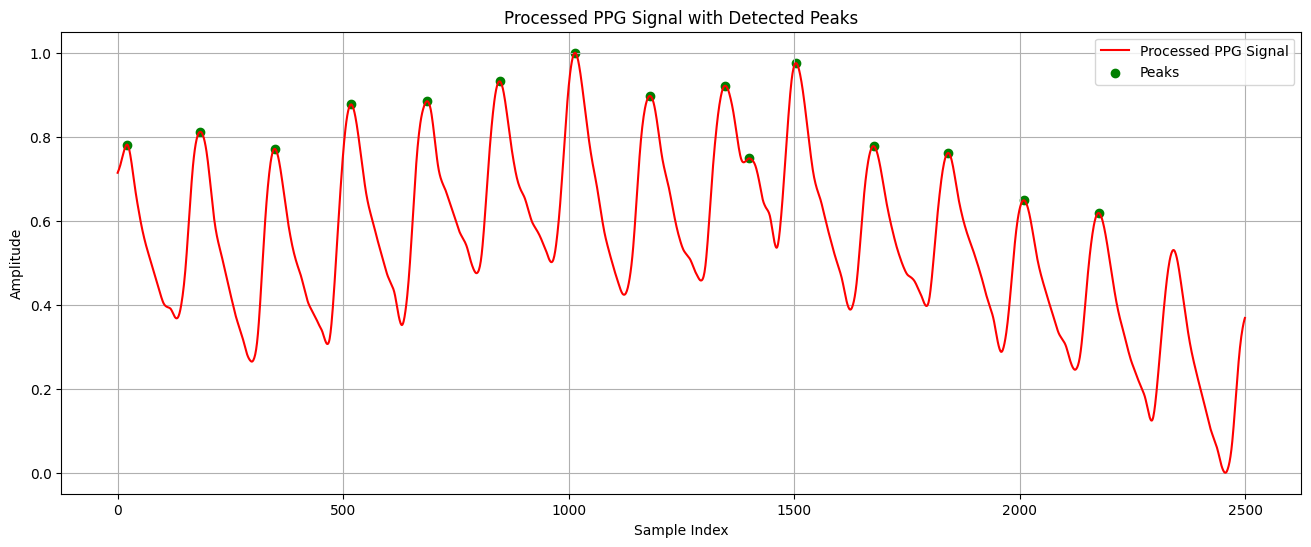

In [70]:
# Assuming `extract_ppg_features` returns peak features and peak points
features, peaks = extract_ppg_features(processed_segments[6], fs)

# Plot the processed PPG signal
plt.figure(figsize=(16, 6))
plt.plot(processed_segments[6], label='Processed PPG Signal', color='red')

# Plot the detected peaks
plt.scatter(peaks, processed_segments[6][peaks], color='green', label='Peaks')

plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.title('Processed PPG Signal with Detected Peaks')
plt.legend()
plt.grid(True)
plt.show()

In [71]:
features, peaks = extract_ppg_features(processed_segments[0],fs)

/tmp/ipykernel_43009/2150020350.py:70: RuntimeWarning: divide by zero encountered in scalar divide
  amplitude_ratio = sa / Da


In [72]:
features

[{'sa': 0.9809083922120247,
  'Da': 0.2538622235257515,
  'SA': 1.4902409706653952,
  'DA': 4.117623943672259,
  'St': 0.316,
  'Dt': 9.684,
  'PI': 0,
  'PPI': 0,
  'PW': 432.0,
  'FWHM': 1.956,
  'Dominant_frequency': 0.0,
  'Spectral_entropy': -5055.633095414664,
  'Signal_area': 5.607864914337654,
  'Rise_time': 0.316,
  'Fall_time': 2.0,
  'Amplitude_modulation_depth': 0.7270461686862733,
  'Energy': 264.41985044906573,
  'Zero_crossing_rate': 0.0,
  'Mean': 0.644543900952092,
  'Median': 0.6344146709971253,
  'Standard_deviation': 0.20309317880599792,
  'Skewness': -0.05069995784665806,
  'Kurtosis': -1.0898213727502677,
  'Min_value': 0.2538622235257515,
  'Max_value': 0.9809083922120247,
  'Variance': 0.041246839277525045,
  'Slope': 0.10055302139755666,
  'Peak_count': 15,
  'Amplitude_ratio': 3.8639399694398504,
  'Area_ratio': 0.36191769599443796,
  'Interval_ratio': 0},
 {'sa': 0.9809083922120247,
  'Da': 0.2538622235257515,
  'SA': 1.9554015435249248,
  'DA': 3.65246337081

In [73]:
def plot_multiple_ppg_with_peaks(ppg_signals, fs):
    plt.figure(figsize=(20, 10))
    all_peaks = []  # List to store all prominent peaks

    for i, ppg_signal in enumerate(ppg_signals):
        duration = len(ppg_signal) / fs
        time = np.linspace(0, duration, len(ppg_signal))

        plt.plot(time, ppg_signal, label=f'PPG Signal {i+1}')

        # Detect prominent peaks in the current PPG signal
        peak_height_threshold = 0.5 * np.max(ppg_signal)  # Adjust the threshold as needed
        peaks, _ = find_peaks(ppg_signal, height=peak_height_threshold)
        all_peaks.append(peaks)  # Store the peaks for all signals

    # Plot all prominent peaks together
    all_peaks_flat = [peak / fs for peaks in all_peaks for peak in peaks]
    all_peaks_amplitudes = [ppg_signal[peak] for peaks, ppg_signal in zip(all_peaks, ppg_signals) for peak in peaks]
    plt.scatter(all_peaks_flat, all_peaks_amplitudes, color='red', label='Prominent Peaks')

    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Multiple PPG Signals with Prominent Peaks')
    plt.legend()
    plt.grid(True)
    plt.show()


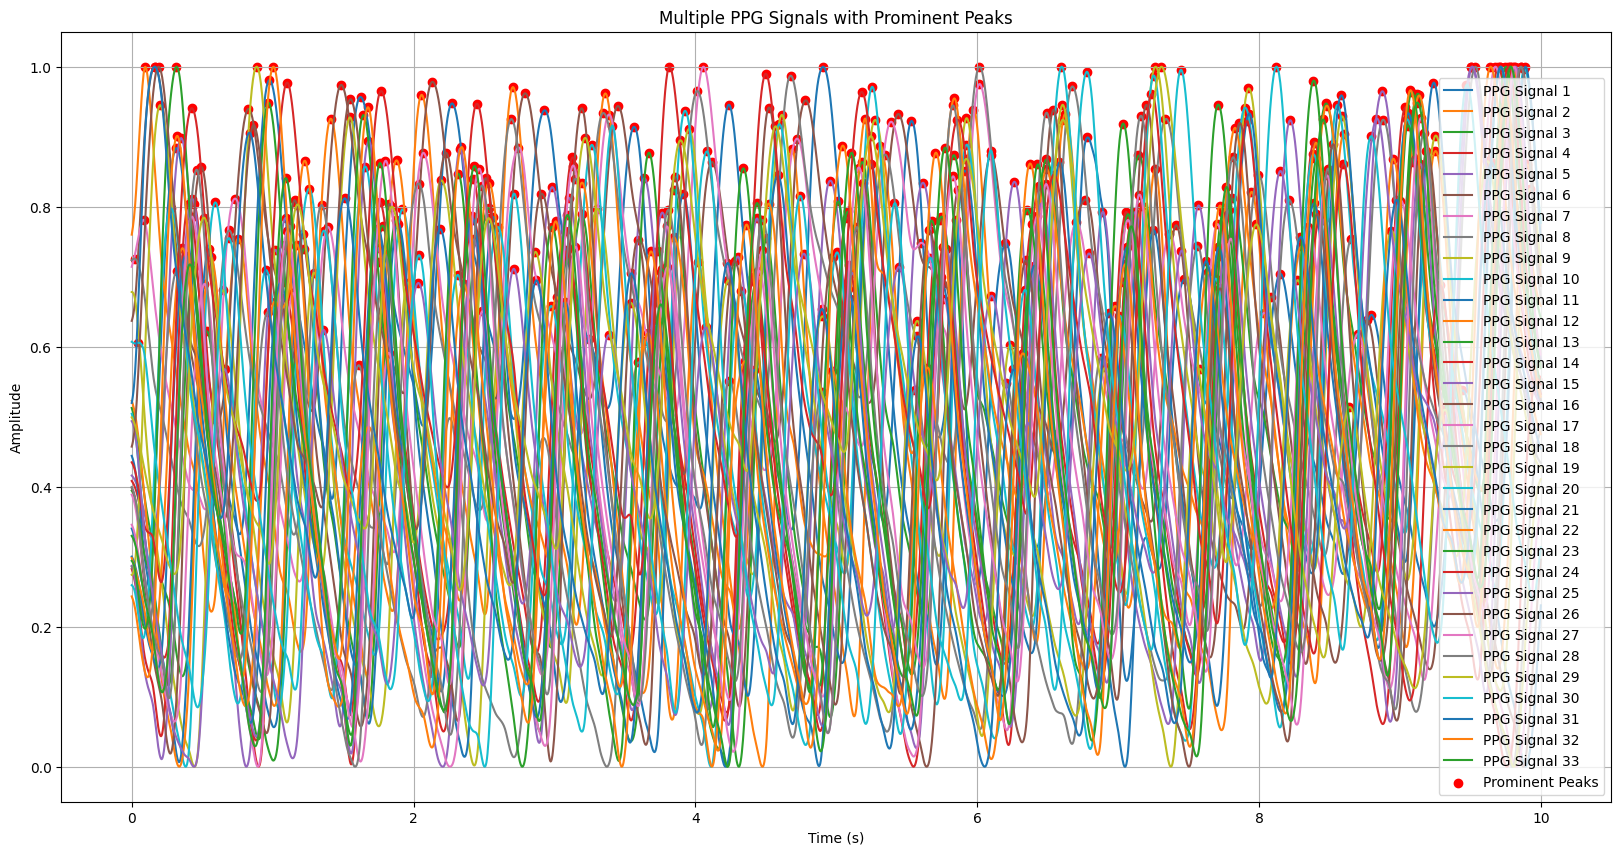

In [74]:
plot_multiple_ppg_with_peaks(processed_segments,fs)

### **Classifying the Dataset**

In [75]:
electrical_activity_counts = {}

for patient_info in pleth_infos.values():
    electrical_activity = patient_info.get('electrical_activity')
    electrical_activity_counts[electrical_activity] = electrical_activity_counts.get(electrical_activity, 0) + 1
print("Unique electrical activities and their counts:")
for activity, count in electrical_activity_counts.items():
    print(f"{activity}: {count}")

Unique electrical activities and their counts:
Ventricular_Tachycardia: 341
Asystole: 122
Tachycardia: 140
Ventricular_Flutter_Fib: 58
Bradycardia: 89


In [76]:
# Initialize a dictionary to store patient IDs for each unique electrical activity
patient_ids_by_activity = {}

# Iterate through the nested dictionaries in pleth_infos
for patient_id, patient_info in pleth_infos.items():
    # Extract the electrical activity for the current patient
    electrical_activity = patient_info.get('electrical_activity')
    # Extract the validity of the electrical activity
    validity = patient_info.get('validity')

    # Check if the validity is 'True alarm'
    if validity == 'True alarm':
        # Add the patient ID to the list associated with the electrical activity
        if electrical_activity:
            if electrical_activity not in patient_ids_by_activity:
                patient_ids_by_activity[electrical_activity] = []
            patient_ids_by_activity[electrical_activity].append(patient_id)

# Print the list of patient IDs for each unique electrical activity
print("List of patient IDs for each unique electrical activity with validity 'True alarm':")
for activity, patient_ids in patient_ids_by_activity.items():
    print(f"{activity}: {patient_ids}")


List of patient IDs for each unique electrical activity with validity 'True alarm':
Tachycardia: ['t106s', 't107l', 't108s', 't110s', 't112s', 't114s', 't117l', 't118s', 't149l', 't150s', 't151l', 't156s', 't157l', 't173l', 't174s', 't175l', 't191l', 't192s', 't193l', 't195l', 't208s', 't209l', 't213l', 't214s', 't234s', 't235l', 't238s', 't240s', 't249l', 't251l', 't252s', 't263l', 't264s', 't270s', 't276s', 't277l', 't284s', 't300s', 't305l', 't320s', 't333l', 't335l', 't342s', 't343l', 't344s', 't350s', 't351l', 't356s', 't357l', 't358s', 't393l', 't394s', 't406s', 't410s', 't411l', 't412s', 't413l', 't416s', 't417l', 't418s', 't424s', 't425l', 't430s', 't434s', 't444s', 't445l', 't447l', 't458s', 't467l', 't468s', 't477l', 't478s', 't506s', 't507l', 't508s', 't509l', 't520s', 't521l', 't524s', 't546s', 't547l', 't565l', 't567l', 't577l', 't580s', 't589l', 't594s', 't595l', 't614s', 't622s', 't662s', 't665l', 't677l', 't678s', 't679l', 't680s', 't683l', 't688s', 't689l', 't690s', 't

In [77]:
max_length = 6

for key, arr in patient_ids_by_activity.items():
    if len(arr) > max_length:
        patient_ids_by_activity[key] = arr[:max_length]


---

# **Dataset Formation**

In [ ]:
dataset = []
i=0
for label, patient_ids in patient_ids_by_activity.items():
    for patient_id in patient_ids:
        if patient_id not in pleth_signals:
            print(f"Patient ID {patient_id} not found in pleth_signal dictionary")
            continue
        fs = pleth_infos[patient_id]['frequency']
        segmented_signal = segment_signal(pleth_signals[patient_id], 10, fs)

        for segment in segmented_signal:
            segment_processed = bandpass_filter(segment, lowcut=0.05, highcut=10, fs=fs)
            segment_processed = moving_average(segment_processed, window_size= 3)
            segment_processed = remove_baseline_wandering(segment_processed)

            if not any(segment_processed):
                continue

            # segment_processed = normalize_signal(segment_processed)

            # dataset.append((label,segment_processed))

            features, peaks = extract_ppg_features(segment_processed,fs)
            for feature in features:
              print(i)

              peak_array = [feature[key] for key in feature.keys()]

              dataset.append((label, peak_array))
              i += 1


In [79]:
len(dataset)

15949

In [80]:
from tensorflow.keras.utils import to_categorical

Separate labels and signals: Extract labels and signals from your array of tuples.

In [81]:
labels = [label for label, _ in dataset]
signals = [signal for _, signal in dataset]

**Convert labels to one-hot encoding**: Convert your labels into one-hot encoded vectors to match the output shape expected by the models.

In [82]:
# Convert labels to one-hot encoding
unique_labels = set(labels)
label_to_index = {label: i for i, label in enumerate(unique_labels)}
index_to_label = {i: label for label, i in label_to_index.items()}
encoded_labels = [to_categorical(label_to_index[label], num_classes=len(unique_labels)) for label in labels]


**Prepare input sequences**: Convert your signals into sequences that can be fed into the LSTM or BiLSTM models. Assuming each signal is of fixed length and you want to pad them to a maximum length.

In [83]:
# Prepare input sequences
# Assuming each signal is of fixed length and you want to pad them to a maximum length
max_length = max(len(signal) for signal in signals)
padded_signals = [np.pad(signal, (0, max_length - len(signal))) for signal in signals]


**Convert to numpy arrays:** Convert the labels and padded signals into numpy arrays.


In [84]:
# Convert to numpy arrays
X = np.array(padded_signals)
y = np.array(encoded_labels)


**Split data into train and test sets**: Split your data into training and testing sets. Replace this with your actual splitting logic.

In [85]:
# Split data into train and test sets (replace with your actual splitting logic)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [86]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


**Define input shape and number of classes:** Define the input shape and the number of classes based on your data.

In [87]:
# Define input shape
input_shape = X_train.shape[1:]  # Shape of input features

# Define number of classes
num_classes = len(unique_labels)


**Create and compile models**: Create and compile your LSTM and BiLSTM models.

In [88]:

def create_lstm_model(input_shape, num_classes):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        LSTM(64), 
        Dense(32, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model

In [89]:
def create_bilstm_model(input_shape, num_classes):
    model = Sequential([
        Bidirectional(LSTM(64, return_sequences=True), input_shape=input_shape),
        Bidirectional(LSTM(64)),  # Second layer of Bidirectional LSTM
        Dense(32, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model

In [167]:
# Create and compile LSTM model
lstm_model = create_lstm_model(input_shape, num_classes)
lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.summary()

# Create and compile BiLSTM model
bilstm_model = create_bilstm_model(input_shape, num_classes)
bilstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
bilstm_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 31, 64)            16896     
                                                                 
 lstm_9 (LSTM)               (None, 64)                33024     
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dense_9 (Dense)             (None, 5)                 165       
                                                                 
Total params: 52165 (203.77 KB)
Trainable params: 52165 (203.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param

**Train the models:** Train your LSTM and BiLSTM models.


In [168]:
# Train the LSTM model
history_lstm = lstm_model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))

# Train the BiLSTM model
history_bilstm = bilstm_model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/50


200/200 [==============================] - 5s 18ms/step - loss: 1.4583 - accuracy: 0.3397 - val_loss: 1.3988 - val_accuracy: 0.3655
Epoch 2/50
200/200 [==============================] - 3s 16ms/step - loss: 1.2339 - accuracy: 0.4687 - val_loss: 1.1449 - val_accuracy: 0.5119
Epoch 3/50
200/200 [==============================] - 3s 16ms/step - loss: 1.0925 - accuracy: 0.5518 - val_loss: 1.0466 - val_accuracy: 0.5850
Epoch 4/50
200/200 [==============================] - 3s 16ms/step - loss: 1.0034 - accuracy: 0.6008 - val_loss: 0.9875 - val_accuracy: 0.6082
Epoch 5/50
200/200 [==============================] - 3s 16ms/step - loss: 0.9480 - accuracy: 0.6157 - val_loss: 0.9579 - val_accuracy: 0.6144
Epoch 6/50
200/200 [==============================] - 3s 16ms/step - loss: 0.8839 - accuracy: 0.6494 - val_loss: 0.8940 - val_accuracy: 0.6361
Epoch 7/50
200/200 [==============================] - 3s 16ms/step - loss: 0.8415 - accuracy: 0.6626 - val_loss: 0.8595 - val_accuracy: 0.6599
Epoch 8/50

In [92]:
lstm_evaluation = lstm_model.evaluate(X_test, y_test)
print("LSTM Evaluation (Untrained Dataset):", lstm_evaluation)

bilstm_evaluation = bilstm_model.evaluate(X_test, y_test)
print("BiLSTM Evaluation (Untrained Dataset):", bilstm_evaluation)


100/100 [==============================] - 0s 4ms/step - loss: 0.5888 - accuracy: 0.8279
LSTM Evaluation (Untrained Dataset): [0.5887748003005981, 0.827899694442749]
 70/100 [====================>.........] - ETA: 0s - loss: 0.6438 - accuracy: 0.8375

100/100 [==============================] - 1s 6ms/step - loss: 0.6291 - accuracy: 0.8395
BiLSTM Evaluation (Untrained Dataset): [0.6290794014930725, 0.8394984602928162]


In [93]:
lstm_evaluation_trained = lstm_model.evaluate(X_train, y_train)
print("LSTM Evaluation (Trained Dataset):", lstm_evaluation_trained)

bilstm_evaluation_trained = bilstm_model.evaluate(X_train, y_train)
print("BiLSTM Evaluation (Trained Dataset):", bilstm_evaluation_trained)


399/399 [==============================] - 2s 4ms/step - loss: 0.1493 - accuracy: 0.9482
LSTM Evaluation (Trained Dataset): [0.1493038684129715, 0.9481934309005737]
389/399 [============================>.] - ETA: 0s - loss: 0.0956 - accuracy: 0.9687

399/399 [==============================] - 2s 5ms/step - loss: 0.0948 - accuracy: 0.9689
BiLSTM Evaluation (Trained Dataset): [0.09480977803468704, 0.9688847064971924]


In [94]:
# Save the trained models
lstm_model.save('/home/nakul/Documents/Python/Arrhythmia_Classification_PPG/lstm_model.h5')
bilstm_model.save('/home/nakul/Documents/Python/Arrhythmia_Classification_PPG/bilstm_model.h5')

print("Models saved yaaaaay")

Models saved yaaaaay


/home/nakul/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


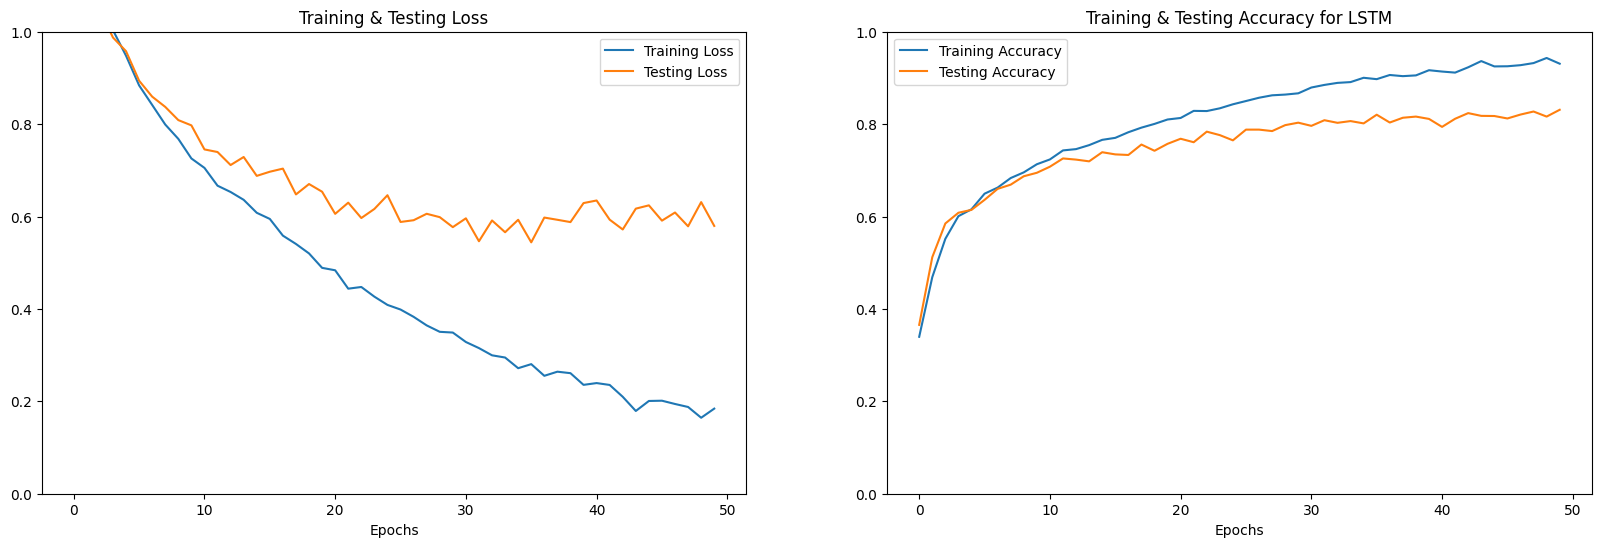

In [171]:
epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history_lstm.history['accuracy']
train_loss = history_lstm.history['loss']
test_acc = history_lstm.history['val_accuracy']
test_loss = history_lstm.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylim(0, 1)

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy for LSTM')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylim(0, 1)
plt.show()

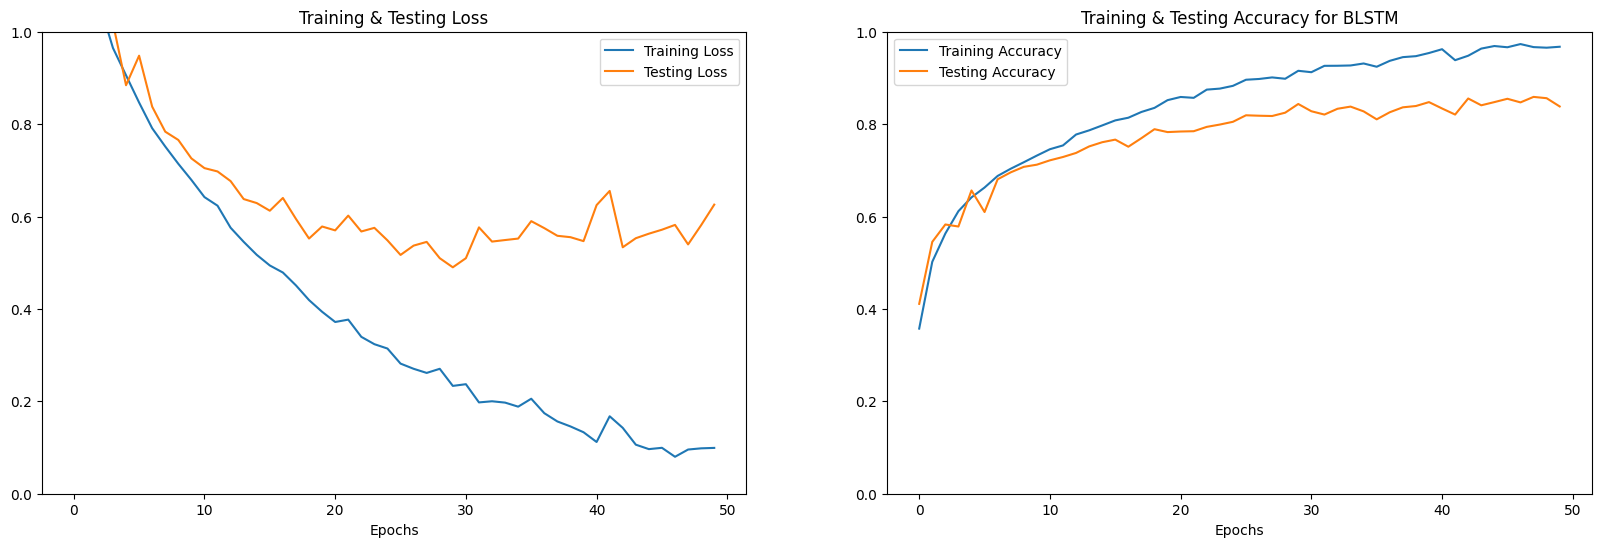

In [170]:
epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history_bilstm.history['accuracy']
train_loss = history_bilstm.history['loss']
test_acc = history_bilstm.history['val_accuracy']
test_loss = history_bilstm.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylim(0, 1)

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy for BLSTM')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylim(0, 1)
plt.show()

In [97]:
lstm_predictions = lstm_model.predict(X_test)
bilstm_predictions = bilstm_model.predict(X_test)

# Convert predictions to class labels
lstm_pred_labels = np.argmax(lstm_predictions, axis=1)
bilstm_pred_labels = np.argmax(bilstm_predictions, axis=1)

100/100 [==============================] - 1s 6ms/step


In [98]:
lstm_predictions_train = lstm_model.predict(X_train)
bilstm_predictions_train = bilstm_model.predict(X_train)

# Convert predictions to class labels
lstm_pred_labels_train = np.argmax(lstm_predictions_train, axis=1)
bilstm_pred_labels_train = np.argmax(bilstm_predictions_train, axis=1)



399/399 [==============================] - 2s 5ms/step


In [99]:
y_test_labels = np.argmax(y_test, axis=1)

In [100]:
y_train_labels = np.argmax(y_train, axis=1)

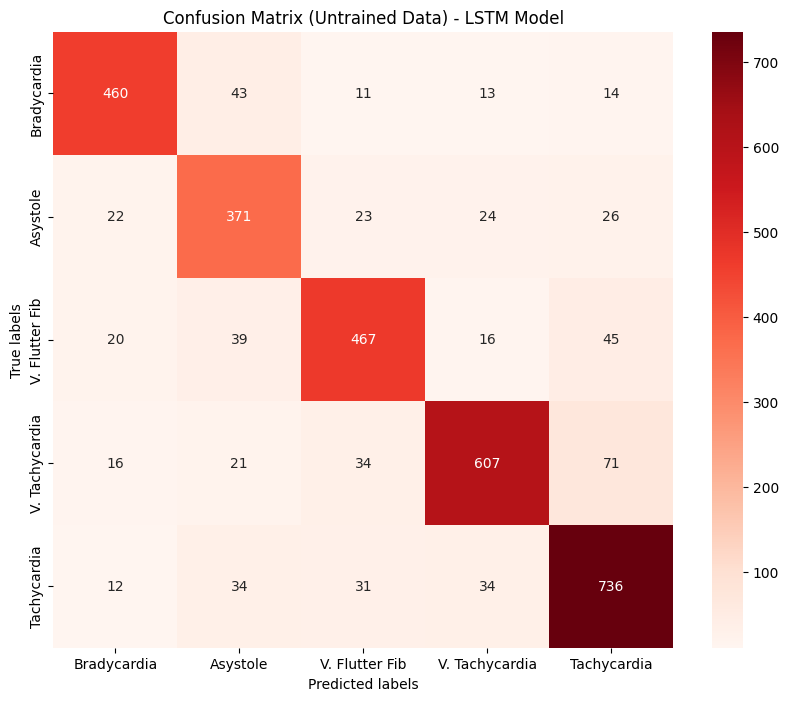

In [213]:
class_labels = [ 'Bradycardia'  ,  'Asystole', 'V. Flutter Fib',  'V. Tachycardia' ,'Tachycardia']


# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_labels, lstm_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
seaborn.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds',
                xticklabels=class_labels,  
                yticklabels=class_labels) 
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix (Untrained Data) - LSTM Model')
plt.show()




In [214]:
# Calculate True Positives, True Negatives, False Positives, and False Negatives
TP = conf_matrix[1, 1]
TN = conf_matrix[0, 0]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]

# Calculate accuracy
accuracy = (TP + TN) / (TP + TN + FN + FP)

# Calculate sensitivity
sensitivity = TP / (TP + FN)

# Calculate specificity
specificity = TN / (TN + FP)

print("Accuracy (Untrained Dataset):", accuracy)
print("Sensitivity (Untrained Dataset):", sensitivity)
print("Specificity (Untrained Dataset):", specificity)


Accuracy (Untrained Dataset): 0.9274553571428571
Sensitivity (Untrained Dataset): 0.9440203562340967
Specificity (Untrained Dataset): 0.9145129224652088


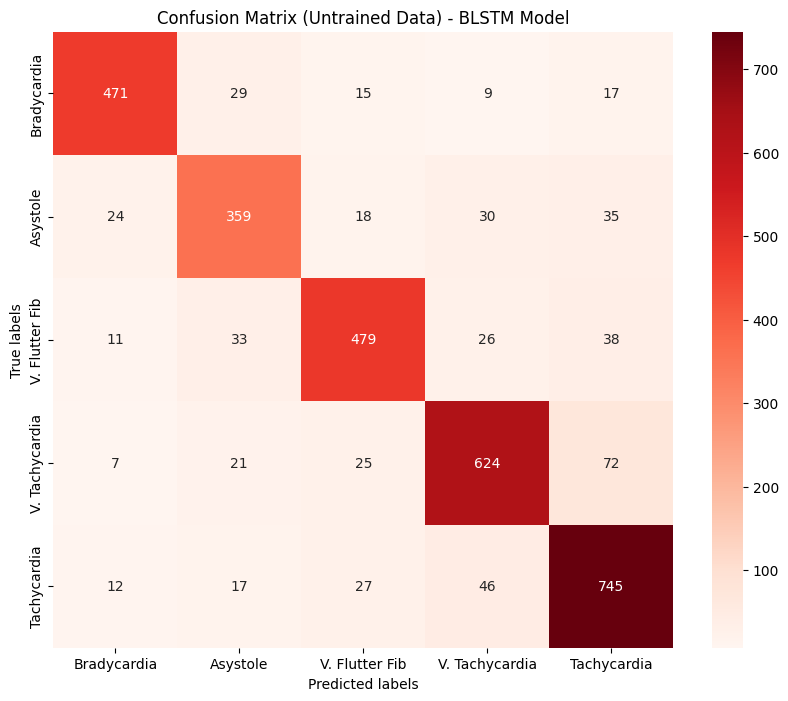

In [215]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_labels, bilstm_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
seaborn.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds',
            xticklabels=class_labels,  
            yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix (Untrained Data) - BLSTM Model')
plt.show()



In [216]:
# Calculate True Positives, True Negatives, False Positives, and False Negatives
TP = conf_matrix[1, 1]
TN = conf_matrix[0, 0]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]

# Calculate accuracy
accuracy = (TP + TN) / (TP + TN + FN + FP)

# Calculate sensitivity
sensitivity = TP / (TP + FN)

# Calculate specificity
specificity = TN / (TN + FP)

print("Accuracy (Untrained Dataset):", accuracy)
print("Sensitivity (Untrained Dataset):", sensitivity)
print("Specificity (Untrained Dataset):", specificity)


Accuracy (Untrained Dataset): 0.9399773499433749
Sensitivity (Untrained Dataset): 0.9373368146214099
Specificity (Untrained Dataset): 0.942


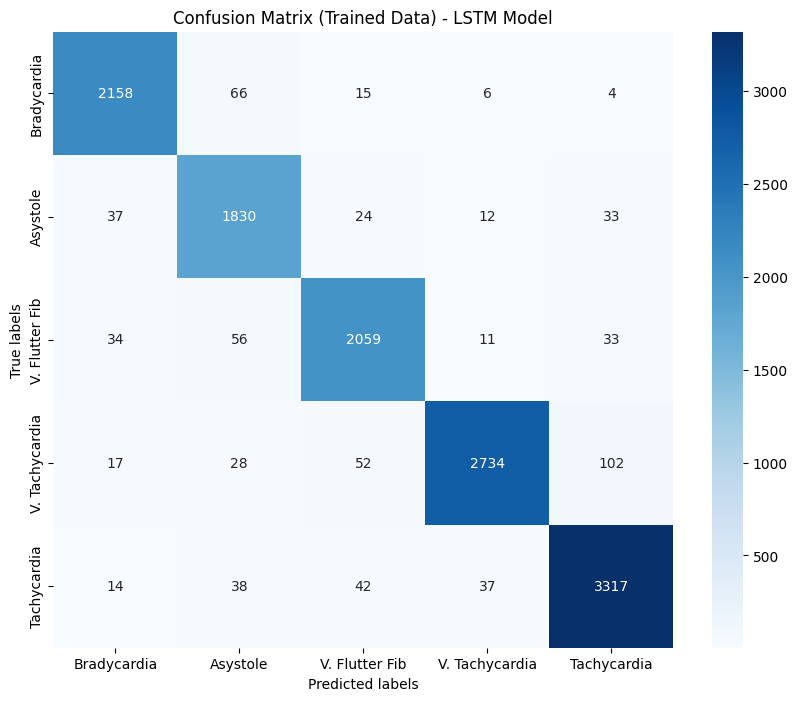

In [217]:

# Compute confusion matrix
conf_matrix_train = confusion_matrix(y_train_labels, lstm_pred_labels_train)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
seaborn.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,  
            yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix (Trained Data) - LSTM Model')
plt.show()

In [218]:

# Calculate True Positives, True Negatidef collectInput(self):

TP = conf_matrix_train[1, 1]
TN = conf_matrix_train[0, 0]
FP = conf_matrix_train[0, 1]
FN = conf_matrix_train[1, 0]

# Calculate accuracy
accuracy = (TP + TN) / (TP + TN + FN + FP)

# Calculate sensitivity
sensitivity = TP / (TP + FN)

# Calculate specificity
specificity = TN / (TN + FP)

print("Accuracy (Trained Dataset):", accuracy)
print("Sensitivity (Trained Dataset):", sensitivity)
print("Specificity (Trained Dataset):", specificity)

Accuracy (Trained Dataset): 0.9748227817159618
Sensitivity (Trained Dataset): 0.9801821103374397
Specificity (Trained Dataset): 0.9703237410071942


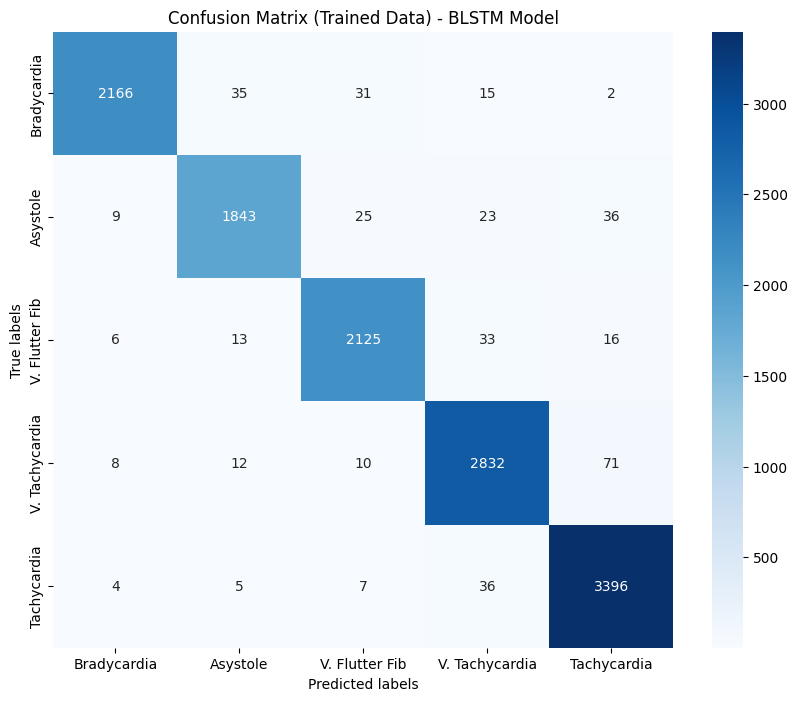

In [221]:

# Compute confusion matrix
conf_matrix_train = confusion_matrix(y_train_labels, bilstm_pred_labels_train)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
seaborn.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,  
            yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix (Trained Data) - BLSTM Model')
plt.show()

In [220]:

# Calculate True Positives, True Negatidef collectInput(self):

TP = conf_matrix_train[1, 1]
TN = conf_matrix_train[0, 0]
FP = conf_matrix_train[0, 1]
FN = conf_matrix_train[1, 0]

# Calculate accuracy
accuracy = (TP + TN) / (TP + TN + FN + FP)

# Calculate sensitivity
sensitivity = TP / (TP + FN)

# Calculate specificity
specificity = TN / (TN + FP)

print("Accuracy (Trained Dataset):", accuracy)
print("Sensitivity (Trained Dataset):", sensitivity)
print("Specificity (Trained Dataset):", specificity)

Accuracy (Trained Dataset): 0.9891438440661239
Sensitivity (Trained Dataset): 0.9951403887688985
Specificity (Trained Dataset): 0.9840981372103589


---

# **Model Testing**

Now that the Model is trained its time to test the Model by giving data from the datset and outside the dataset

In [156]:
# Assuming you have already trained your model
lstm_model_test = keras.models.load_model('/home/nakul/Documents/Python/Arrhythmia_Classification_PPG/lstm_model.h5')
bilstm_model_test = keras.models.load_model('/home/nakul/Documents/Python/Arrhythmia_Classification_PPG/bilstm_model.h5')

In [161]:
data = dataset[random.randint(0,len(dataset))]

input = data[1]
label = data[0]

print(label , input)

Ventricular_Flutter_Fib [1754.2313029955646, -3282.1048897207684, -1960.7128531600256, 972.6767297642912, 4.772, 5.228, 0.624, 0.624, 80.0, 2.964, 1.25, -123595294.74794412, -988.0361233957344, 2.0000000000000004, 2.0, 5036.336192716333, 1333047137.430105, 0.009, -489.64726263183167, -357.94613390851134, 1045.6063770020048, -0.36463463364166293, -0.11497016045357977, -3282.1048897207684, 1754.2313029955646, 1093292.6956272589, -11.426519051014022, 19, -0.5344836200968609, -2.015790851329573, 1.0]


In [162]:
input_data = np.array(input).reshape(1, 31, 1)

raw_predictions = lstm_model_test.predict(input_data)

predicted_label_index = np.argmax(raw_predictions)
predicted_percentage = raw_predictions[0][predicted_label_index]

class_labels = [ 'Bradycardia'  ,  'Asystole', 'Ventricular Flutter Fib',  'Ventricular Tachycardia' ,'Tachycardia']
predicted_label = class_labels[predicted_label_index]

prediction_dict = {}
for label, raw_prediction in zip(class_labels, raw_predictions[0]):
    prediction_dict[label] = f"{raw_prediction*100}%"

prediction_dict


1/1 [==============================] - 0s 16ms/step


{'Bradycardia': '1.117078838319685e-05%',
 'Asystole': '0.023479669471271336%',
 'Ventricular Flutter Fib': '99.44393634796143%',
 'Ventricular Tachycardia': '0.414813868701458%',
 'Tachycardia': '0.11776362080127001%'}

---

## **GUI Generation**

##### Generating Random Patient Id from the Database

In [207]:
record_id = patient_ids[random.randint(0,len(patient_ids)-1)]

record_id

'f544s'

##### Extracting their Header and Signal Location

In [208]:
def extracting_database(record_name, data_dir='/home/nakul/Documents/Python/Arrhythmia_Classification_PPG/training'):

    os.makedirs(data_dir, exist_ok=True)

    base_url = 'https://archive.physionet.org/physiobank/database/challenge/2015/training/'

    #!wget -N {base_url + record_name + '.mat'} -P $data_dir
    #!wget -N {base_url + record_name + '.hea'} -P $data_dir # Uncomment these if you dont have the dataset in your drive

    record_path = os.path.join(data_dir, record_name + '.mat')
    hea_file_path = os.path.join(data_dir, record_name + '.hea')

    return record_path, hea_file_path


# Example case

record_path_test, hea_file_path_test = extracting_database(record_id)

##### Extracting their Cardiac Arrhytnmia Info

In [209]:
def extract_pleth_info(file_path):

    pleth_info = {}

    with open(file_path, 'r') as file:
        lines = file.readlines()

        first_line_info = lines[0].split()
        pleth_info['frequency'] = int(first_line_info[2])

        last_three_lines = lines[-3:]
        pleth_info['electrical_activity'] = last_three_lines[1].replace("#", "").replace("\n", "")
        pleth_info['validity'] = last_three_lines[2].replace("#", "").replace("\n", "")
        return pleth_info

file_path = hea_file_path_test
pleth_info_test = extract_pleth_info(file_path)
pleth_info_test

{'frequency': 250,
 'electrical_activity': 'Ventricular_Flutter_Fib',
 'validity': 'True alarm'}

* This funtion take a '.mat' file from the physionet Cardiac Challenge 2015 training database
* Extracts the **PPG Signal** from it 
* Converts it into an array

In [210]:
def extract_pleth_signal(record_path):
    mat_data = scipy.io.loadmat(record_path)
    signals = mat_data['val']
    pleth_signal = signals[2]  # PLETH is the third signal
    return pleth_signal

# Example case
pleth_signal_test = extract_pleth_signal(record_path_test)
pleth_signal_test

array([11467, 15559, 16025, ..., 17028, 17055, 17078], dtype=int16)

* This is the function that has to be called in the GUI so that an the Cardiac Arrhythmia Prediction can be made from the signal when inputed as an array

In [211]:
def predict_arrhythmia(fs, signal, lstm_model_test, class_labels):
    input_features = []
    
    segmented_signal = segment_signal(signal, 10, fs)
    
    for segment in segmented_signal:
        segment_processed = bandpass_filter(segment, lowcut=0.05, highcut=10, fs=fs)
        segment_processed = moving_average(segment_processed, window_size=3)
        segment_processed = remove_baseline_wandering(segment_processed)

        if not any(segment_processed):
            continue

        features, peaks = extract_ppg_features(segment_processed, fs)
        for peak in features:
            peak_array = [peak[key] for key in peak.keys()]
            input_features.append(peak_array)

    input_data = np.array(input_features)
    input_data = input_data.reshape(input_data.shape[0], input_data.shape[1], 1)
    raw_predictions = lstm_model_test.predict(input_data)
    average_prediction = np.mean(raw_predictions, axis=0)
    
    prediction_dict = {}
    for label, percentage in zip(class_labels, average_prediction):
        prediction_dict[label] = f"{percentage*100:.2f}%"

    
    
    return prediction_dict

# Example Usecase
fs = 250
class_labels = [ 'Bradycardia'  ,  'Asystole', 'Ventricular Flutter Fib',  'Ventricular Tachycardia' ,'Tachycardia']

prediction_dict = predict_arrhythmia(fs, pleth_signal_test, lstm_model_test, class_labels)
prediction_dict

16/16 [==============================] - 0s 6ms/step


{'Bradycardia': '5.24%',
 'Asystole': '2.31%',
 'Ventricular Flutter Fib': '88.95%',
 'Ventricular Tachycardia': '2.24%',
 'Tachycardia': '1.26%'}

---